<a href="https://colab.research.google.com/github/jbajaj1/faketweets/blob/master/faketweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.utils.data as data
import handleTwitterSent as TS
from torch.utils.data import TensorDataset, DataLoader

Using TensorFlow backend.


In [5]:
twitterVoc = TS.Vocab("twitter")

#Put proper location of file here
tokenizedTweets, tokenizedLabels, weights = TS.load_tweets("./data/semeval_train.txt", Voc=twitterVoc, initVoc=True)

print(twitterVoc.to_word(4))
print(twitterVoc.to_index("this"))

print(twitterVoc.num_words)

gas
82
28255


In [14]:
from os import listdir
from os.path import isfile, join
from keras.utils import Progbar


emb_list = [64]
hid_list = [64]
num_layers = [1]
dropout = [.1]

completed_models = [f for f in listdir("./models/") if isfile(join("./models/", f)) and ".model" in f]
#completed_models = []
##################
#####Training#####
##################
#(vocab_size, embedding_size, hidden_size, num_layers=2, dropout=0.1)
highPrec = (0, None, None, None)
results_prec = []
for emb in emb_list:
    for hid in hid_list:
        for l in num_layers:
            for d in dropout:
                ourLSTM = TS.LSTM(twitterVoc.num_words, emb, hid, l, d)      
                if f'{emb}_{hid}_{l}_{d}.model' not in completed_models:
                    print(f'Training {emb}_{hid}_{l}_{d}.model')
                    #print(f'{emb}_{hid}_{l}_{d}.model')
                    
                    
                    opt = torch.optim.Adam(ourLSTM.parameters(), lr=.1)
                    epochs = 30
                    dataset = DataLoader(TensorDataset(tokenizedTweets, tokenizedLabels, weights), batch_size=100)
                    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")
                    ourLSTM.train()
                    for i in range(epochs):
                        p = Progbar(len(dataset))
                        for batchidx, (x, y, w) in enumerate(dataset):
                            opt.zero_grad()
                            outputs = ourLSTM(x)
                            lossVal = loss_fn(outputs, y) *w
                            lossVal = lossVal.mean()
                            stateful_metrics = []
                            stateful_metrics.append((f"Train Loss on epoch {i}", lossVal.item()))
                            lossVal.backward()
                            opt.step()
                            p.add(1, stateful_metrics)
                    
                    torch.save(ourLSTM.state_dict(), f'./models/{emb}_{hid}_{l}_{d}.model')
                
                else:
                    ourLSTM = TS.LSTM(twitterVoc.num_words, emb, hid, l, d)      
                    
                    print(f'Loading {emb}_{hid}_{l}_{d}.model')
                    ourLSTM.load_state_dict(torch.load(f'./models/{emb}_{hid}_{l}_{d}.model'))
                    ourLSTM.eval()
                    print(f'Loaded {emb}_{hid}_{l}_{d}.model')
                
                
                
                ##################
                #####Predict######
                ####Evaluation####
                ##################
                #file = "semeval_train_dev.txt"
                files = "Twitter2016_raw.txt", 
                tokTestTweets, tokTestLabels, _ = TS.load_tweets("./data/" + file, twitterVoc)
                with torch.no_grad():
                    predVal = ourLSTM(tokTestTweets).argmax(dim=-1)
                prec, conf, neg_F1, pos_F1, F1 = TS.validate(tokTestLabels, predVal)
                results_prec.append(f'LSTM F1 with emb_size[{emb}], hid_size[{hid}], layers[{l}], and dropout[{d}]: {F1}. Prec: {prec}, pos_F1 {pos_F1}, neg_F1 {neg_F1}')
                if prec > highPrec[0]:
                    highPrec = (F1, conf, len(results_prec) - 1, f'./models/{emb}_{hid}_{l}_{d}.model', prec, pos_F1, neg_F1)
                    


Loading 64_64_1_0.1.model
Loaded 64_64_1_0.1.model


F1 with emb_size[64], hid_size[64], layers[1], and dropout[0.1]: 0.5055778949938674. Prec: 0.5039988367020504, pos_F1 0.4525571725571726, neg_F1 0.33490265937142133
The best F1 performer:
F1 with emb_size[64], hid_size[64], layers[1], and dropout[0.1]: 0.5055778949938674. Prec: 0.5039988367020504, pos_F1 0.4525571725571726, neg_F1 0.33490265937142133
Here are the heatmaps



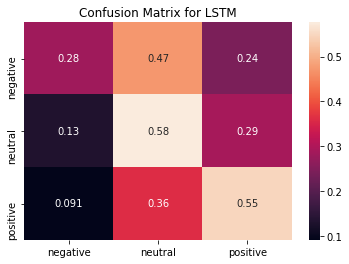

In [62]:
for r in results_prec:
    print(r)
print(f'The best F1 performer:\n{results_prec[highPrec[2]]}\nHere are the heatmaps\n')

import seaborn as sn
from matplotlib import pyplot as plt

%matplotlib inline
fig, ax = plt.subplots()

conf = highPrec[1].T
#Counts graph
#sn.heatmap(conf, annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
#plt.show()
#Percentages graph
ax.set_title("Confusion Matrix for LSTM")
sn.heatmap(conf/conf.sum(1, keepdims=True), annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.show()


In [50]:

#CNN	TRUE	30	128	[32|32]	N/A	1	0.1	100	0.001
emb = 128
hid = [32,32]
kernel = [1]
dropout = .1

##################
#####Training#####
##################

ourCNN = TS.CNN(twitterVoc.num_words, emb, hid, kernel, dropout)      
print(f'Training CNN_{emb}_{hid}_{kernel}_{dropout}.model')

opt = torch.optim.Adam(ourCNN.parameters(), lr=.001)
epochs = 30
dataset = DataLoader(TensorDataset(tokenizedTweets, tokenizedLabels, weights), batch_size=100)
loss_fn = torch.nn.CrossEntropyLoss(reduction="none")
ourCNN.train()
for i in range(epochs):
    p = Progbar(len(dataset))
    for batchidx, (x, y, w) in enumerate(dataset):
        opt.zero_grad()
        outputs = ourCNN(x)
        lossVal = loss_fn(outputs, y) *w
        lossVal = lossVal.mean()
        stateful_metrics = []
        stateful_metrics.append((f"Train Loss on epoch {i}", lossVal.item()))
        lossVal.backward()
        opt.step()
        p.add(1, stateful_metrics)
    
    torch.save(ourCNN.state_dict(), f'./models/CNN_{emb}_{hid}_{kernel}_{dropout}.model')

#else:
#    ourLSTM = TS.LSTM(twitterVoc.num_words, emb, hid, l, d)      
#
#    print(f'Loading {emb}_{hid}_{l}_{d}.model')
#    ourLSTM.load_state_dict(torch.load(f'./models/{emb}_{hid}_{l}_{d}.model'))
#    ourLSTM.eval()
#    print(f'Loaded {emb}_{hid}_{l}_{d}.model')
                
                
                
##################
#####Predict######
####Evaluation####
##################
#file = "semeval_train_dev.txt"
files = "Twitter2016_raw.txt", 
tokTestTweets, tokTestLabels, _ = TS.load_tweets("./data/" + file, twitterVoc)
with torch.no_grad():
    predVal = ourCNN(tokTestTweets).argmax(dim=-1)
prec, conf, neg_F1, pos_F1, F1 = TS.validate(tokTestLabels, predVal)
print(f'CNN F1 with emb_size[{emb}], hid_size[{hid}], kernel[{kernel}], and dropout[{dropout}]: {F1}. Prec: {prec}, pos_F1 {pos_F1}, neg_F1 {neg_F1}')
highPrecCNN = (F1, conf, f'./models/CNN_{emb}_{hid}_{l}_{d}.model', prec, pos_F1, neg_F1)
                    








Training CNN_128_[32, 32]_[1]_0.1.model
87/87 [==============================] - 3s 37ms/step - Train Loss on epoch 29: 0.0238
CNN F1 with emb_size[128], hid_size[[32, 32]], kernel[[1]], and dropout[0.1]: 0.47414089634188594. Prec: 0.4762250981532645, pos_F1 0.5397347106467896, neg_F1 0.36147995359030555


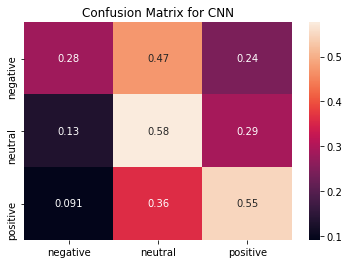

In [66]:
conf = highPrec[1].T
#Counts graph
#sn.heatmap(conf, annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
#plt.show()
#Percentages graph
fig, ax = plt.subplots()

sn.heatmap(conf/conf.sum(1, keepdims=True), annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
ax.set_title("Confusion Matrix for CNN")

plt.show()

cnn_model_values = [highPrecCNN[0], highPrecCNN[3], highPrecCNN[4], highPrecCNN[5]]

In [18]:
import bow_baseline as BoW

trainX_bow, trainY_bow = BoW.load_data('./data/semeval_train_trimmed.txt')
#testX_bow, testY_bow= BoW.load_data('../data/semeval_train_dev.txt')
testX_bow, testY_bow= BoW.load_data('./data/Twitter2016_raw.txt')

classifier = BoW.Classifier()

classifier.train(trainX_bow, trainY_bow)
outputs = classifier.classify(testX_bow)


prec_bow, conf_bow, neg_F1_bow, pos_F1_bow, F1_bow = BoW.validate(outputs, testY_bow)

print(f'F1: {F1_bow}\nAccuracy: {prec_bow}\npos_F1: {pos_F1_bow}\nneg_F1: {neg_F1_bow}')


F1: 0.4202603796366269
Accuracy: 0.43197130531724104
pos_F1: 0.36882743760100556
neg_F1: 0.3103256846780163


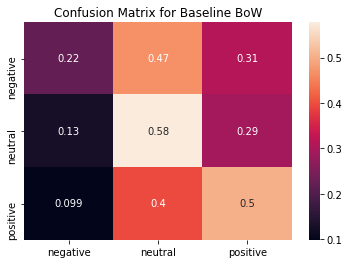

In [65]:
conf_bow = conf_bow.T
#Counts graph
#sn.heatmap(conf_bow, annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
#plt.show()
#Percentages graph
fig, ax = plt.subplots()

ax.set_title("Confusion Matrix for Baseline BoW")
sn.heatmap(conf_bow/conf_bow.sum(1, keepdims=True), annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.show()

In [71]:

lstm_model_values = [highPrec[0], highPrec[4], highPrec[5], highPrec[6]]
bow_model_values = [prec_bow, F1_bow, pos_F1_bow, neg_F1_bow]
x_score_tics = ['F1', 'Accuracy', 'Pos_F1', 'Neg_F1']
print(f'Model: [F1, Accuracy, Pos_F1, Neg_F1]\nCNN_Values: {cnn_model_values}\nLSTM_Values: {lstm_model_values}\nBaseline BoW_Values: {bow_model_values}')

Model: [F1, Accuracy, Pos_F1, Neg_F1]
CNN_Values: [0.47414089634188594, 0.4762250981532645, 0.5397347106467896, 0.36147995359030555]
LSTM_Values: [0.5055778949938674, 0.5039988367020504, 0.4525571725571726, 0.33490265937142133]
Baseline BoW_Values: [0.43197130531724104, 0.4202603796366269, 0.36882743760100556, 0.3103256846780163]


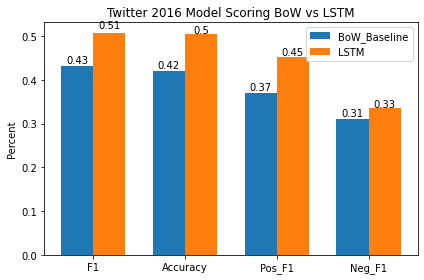

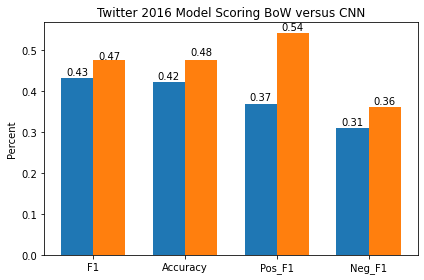

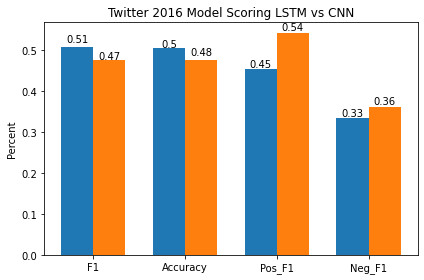

In [72]:


x = np.arange(len(x_score_tics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bow_model_values, width, label='BoW_Baseline')
rects2 = ax.bar(x + width/2, lstm_model_values, width, label='LSTM')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_title('Twitter 2016 Model Scoring BoW vs LSTM')
ax.set_xticks(x)
ax.set_xticklabels(x_score_tics)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        
        height = float(f'{height:.2f}')
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 1 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.show()



x = np.arange(len(x_score_tics))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
ax.set_ylabel('Percent')
ax.set_title('Twitter 2016 Model Scoring BoW versus CNN')
ax.set_xticks(x)
ax.set_xticklabels(x_score_tics)

rects1 = ax.bar(x - width/2, bow_model_values, width, label='BoW_Baseline')
rects2 = ax.bar(x + width/2, cnn_model_values, width, label='CNN')

fig.tight_layout()

autolabel(rects1)

autolabel(rects2)
plt.show()



x = np.arange(len(x_score_tics))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
ax.set_ylabel('Percent')
ax.set_title('Twitter 2016 Model Scoring LSTM vs CNN')
ax.set_xticks(x)
ax.set_xticklabels(x_score_tics)

rects1 = ax.bar(x - width/2, lstm_model_values, width, label='LSTM')
rects2 = ax.bar(x + width/2, cnn_model_values, width, label='CNN')
fig.tight_layout()

autolabel(rects1)

autolabel(rects2)
plt.show()
